# 1. Load data

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

pd.options.mode.chained_assignment = None
sns.mpl.rc("figure", figsize=(15,8))

df_base = pd.read_csv('bank-classification.csv')

# Change type of results column
df_base.y.replace(('yes', 'no'), (1, 0), inplace=True)

# Transform strings into datetimes
df_base['birth_date'] = pd.to_datetime(df_base['birth_date'], format='%Y-%m-%d')
df_base['contact_date'] = pd.to_datetime(df_base['contact_date'], format='%Y-%m-%d')



# 2. Feature engineering

In [5]:
df = df_base.copy()

### New feature - contact weekday

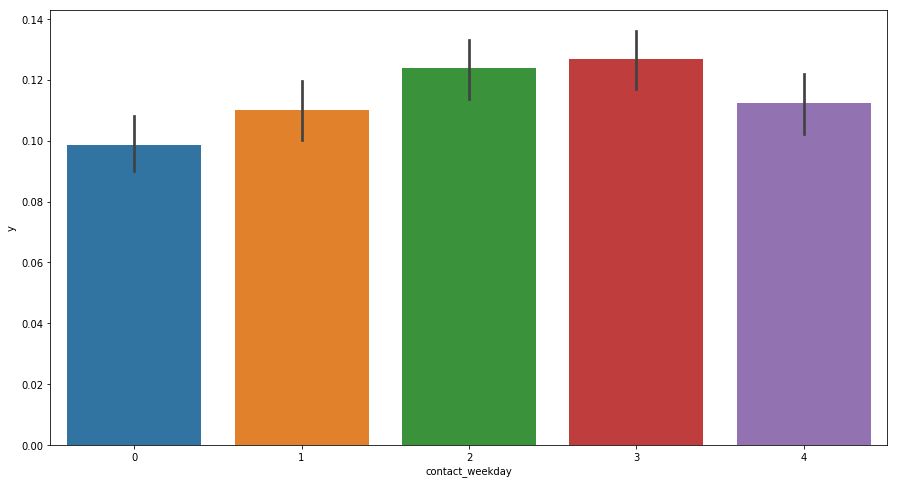

In [6]:
df['contact_weekday'] = df['contact_date'].apply(lambda x: x.weekday())

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact_weekday', y='y', data=learn)
plt.show()

### New feature - contact month

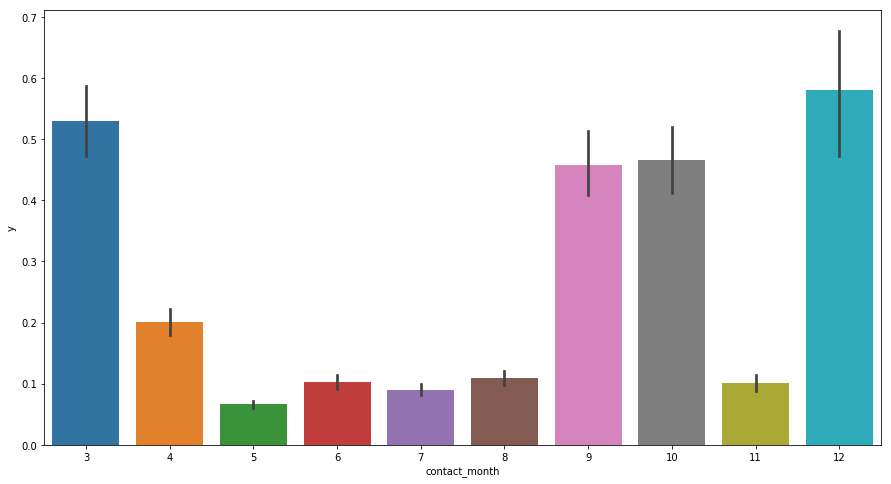

In [7]:
df['contact_month'] = df['contact_date'].apply(lambda x: x.month)

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact_month', y='y', data=learn)
plt.show()

### New feature - contact day

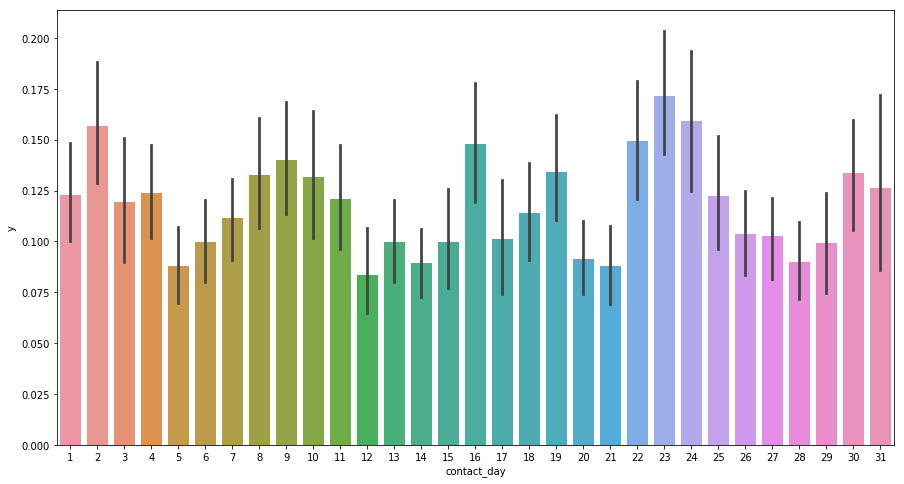

In [8]:
df['contact_day'] = df['contact_date'].apply(lambda x: x.day)

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact_day', y='y', data=learn)
plt.show()

### New feature - birth month

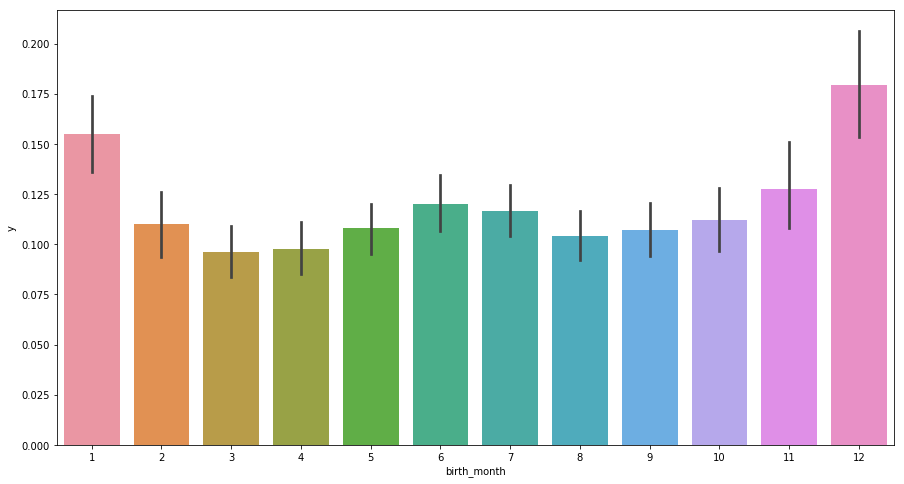

In [9]:
df['birth_month'] = df['birth_date'].apply(lambda x: x.month)

learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='birth_month', y='y', data=learn)
plt.show()

### Feature - job

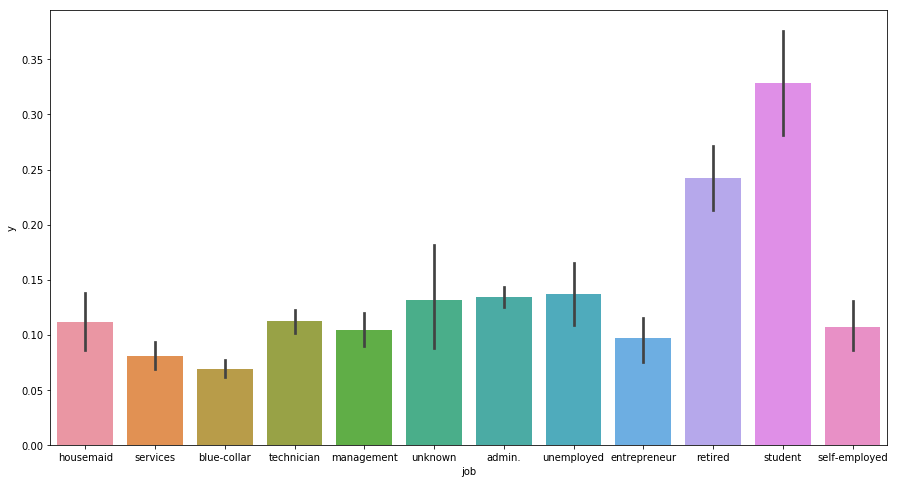

In [10]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='job', y='y', data=learn)
plt.show()


df['job'] = df.job.astype('category').cat.codes

### Feature - marital

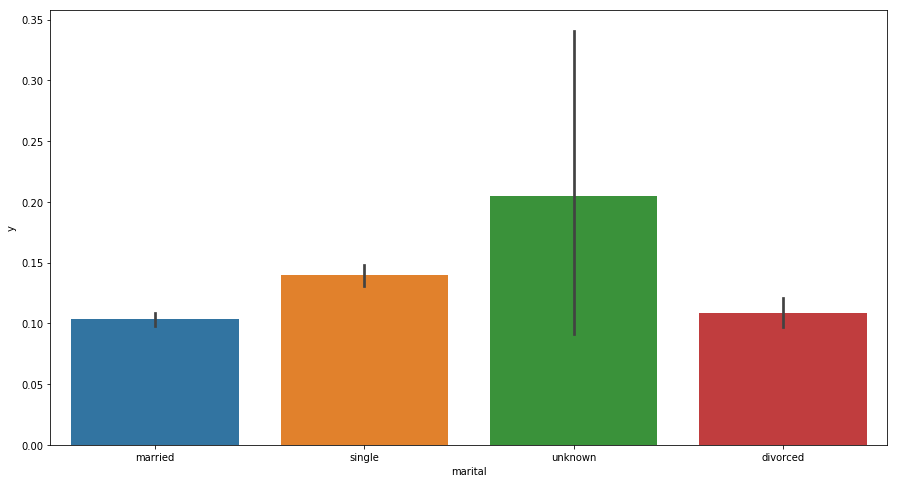

In [11]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='marital', y='y', data=learn)
plt.show()

df['marital'] = df.marital.astype('category').cat.codes

### Feature - education

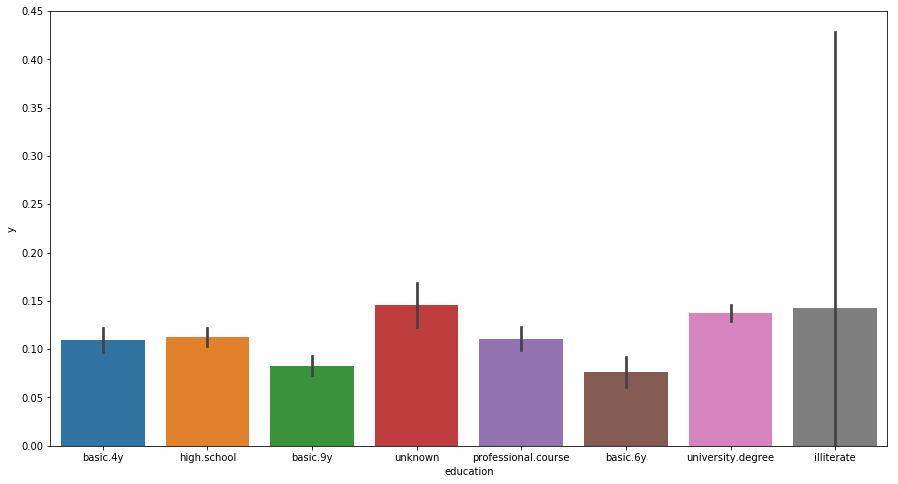

In [12]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='education', y='y', data=learn)
plt.show()

df['education'] = df.education.astype('category').cat.codes

### Feature - default

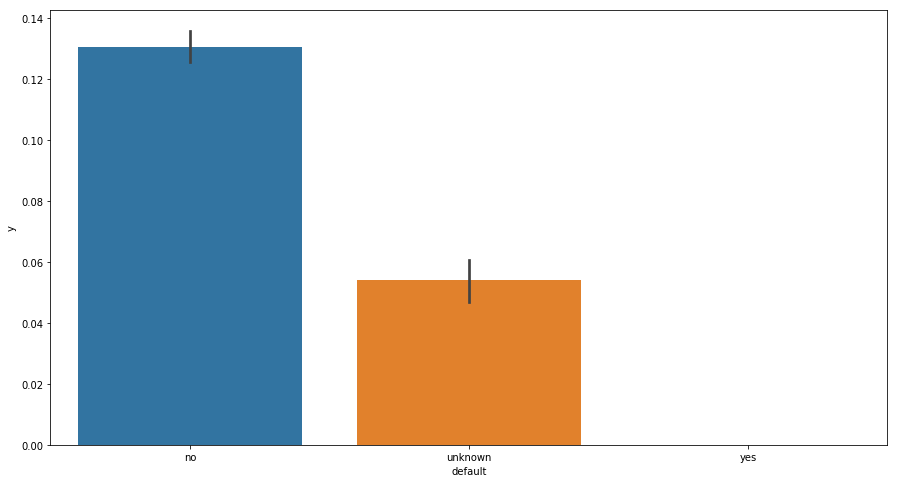

In [13]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='default', y='y', data=learn)
plt.show()

df['default'] = df.default.astype('category').cat.codes

### Feature - housing

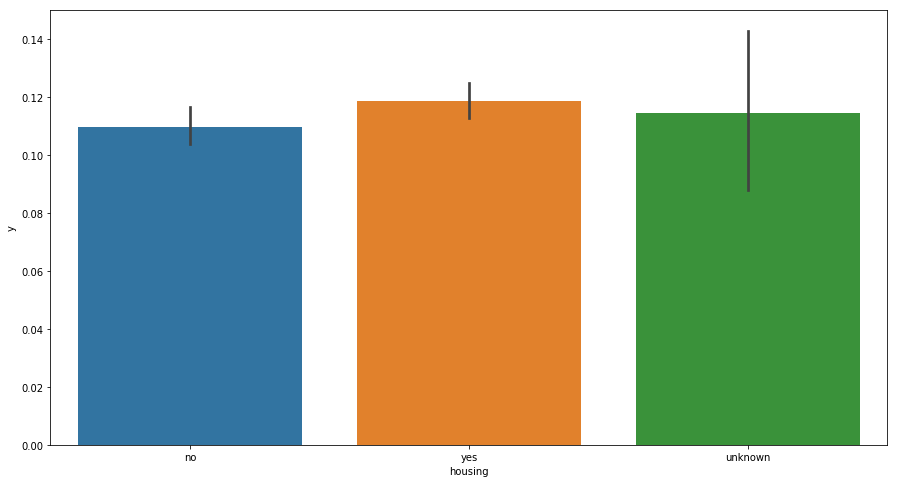

In [14]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='housing', y='y', data=learn)
plt.show()

df['housing'] = df.housing.astype('category').cat.codes

### Feature - loan

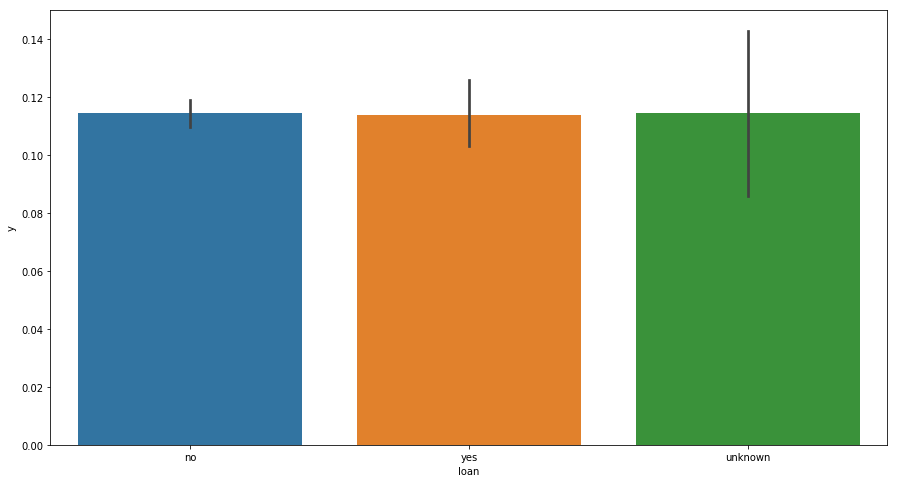

In [15]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='loan', y='y', data=learn)
plt.show()

df['loan'] = df.loan.astype('category').cat.codes

### Feature - contact

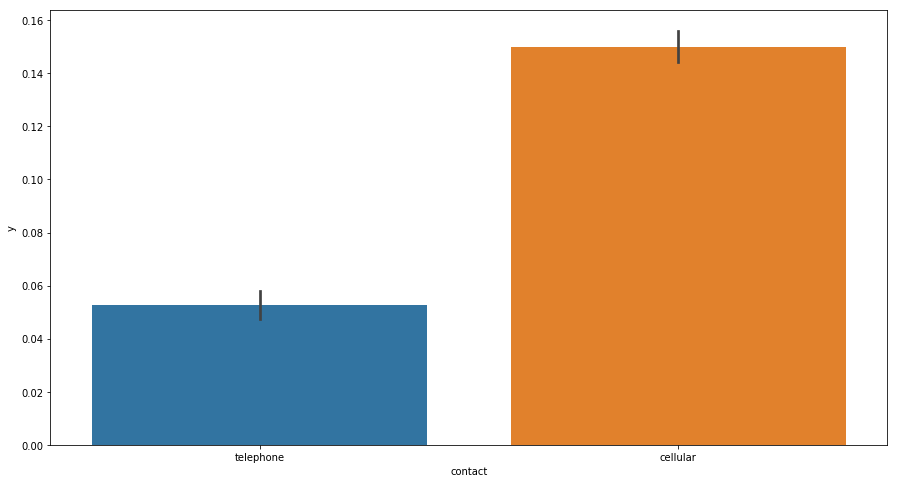

In [16]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='contact', y='y', data=learn)
plt.show()

df.contact.replace(('cellular', 'telephone'), (1, 0), inplace=True)

### Feature - pdays 

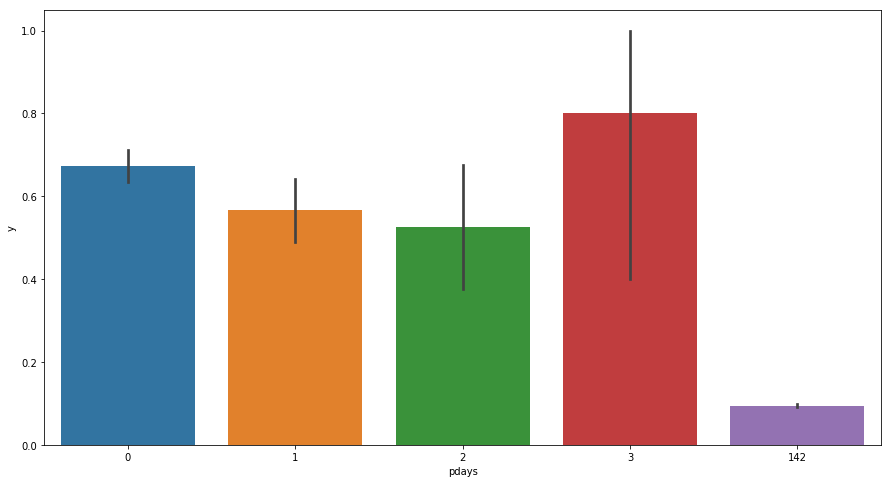

In [17]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn['pdays'] = learn['pdays'].apply(lambda x: x/7)
sns.barplot(x='pdays', y='y', data=learn)
plt.show()

df['pdays'] = df['pdays'].apply(lambda x: x/7)

### Feature - campaign

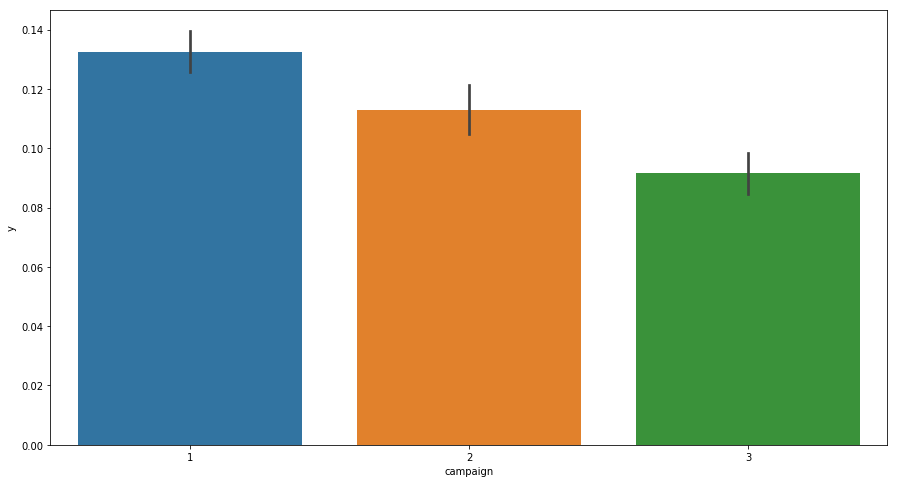

In [18]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn.loc[learn.campaign > 2, 'campaign'] = 3
sns.barplot(x='campaign', y='y', data=learn)
plt.show()

df.loc[df.campaign > 2, 'campaign'] = 3

### Feature - contact_date

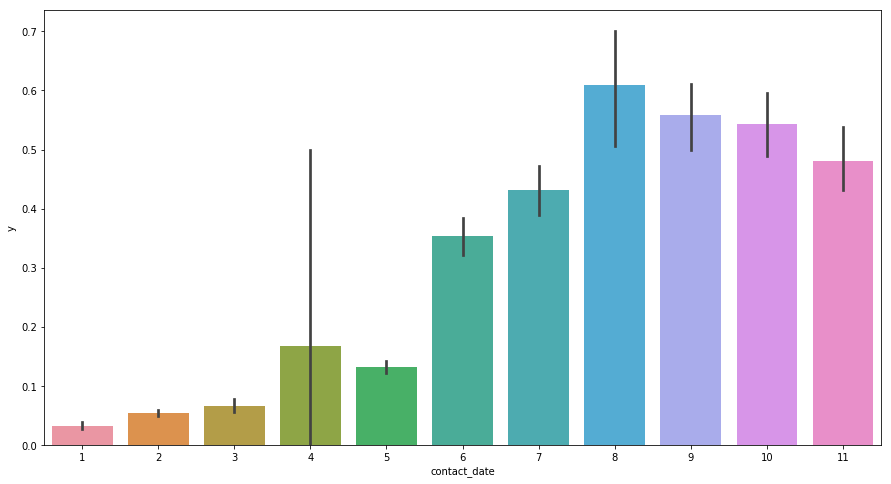

In [19]:
learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn['contact_date'] = learn['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/3)
sns.barplot(x='contact_date', y='y', data=learn)
plt.show()

df['contact_date'] = df['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/3)

### Feature - birth_date

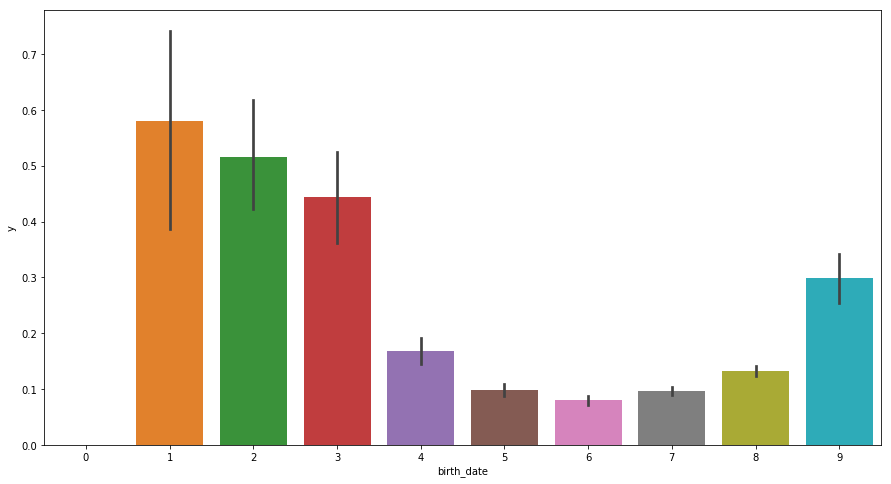

In [20]:
learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn['birth_date'] = learn['birth_date'].apply(lambda x: (x.month + (x.year-1910)*12)/100)
sns.barplot(x='birth_date', y='y', data=learn)
plt.show()

df['birth_date'] = df['birth_date'].apply(lambda x: (x.month + (x.year-1910)*12)/100)

### Feature - poutcome

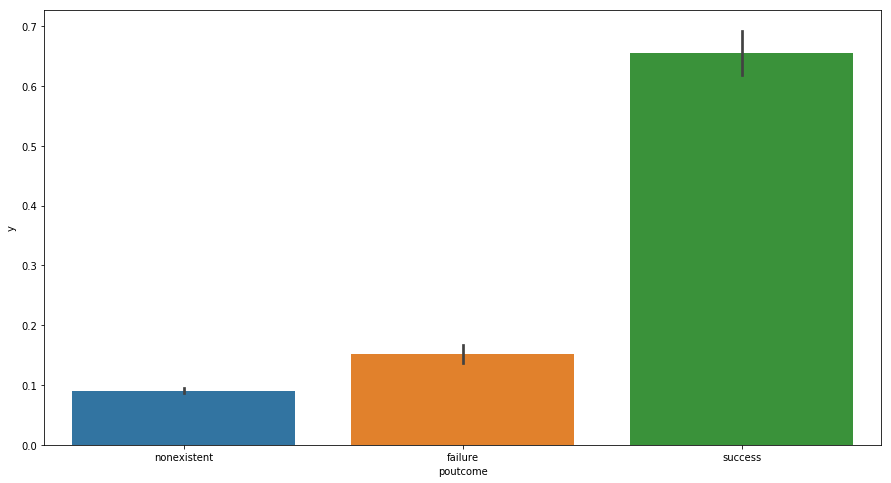

In [21]:
learn = df_base.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='poutcome', y='y', data=learn)
plt.show()

df['poutcome'] = df.poutcome.astype('category').cat.codes

### Feature - previous

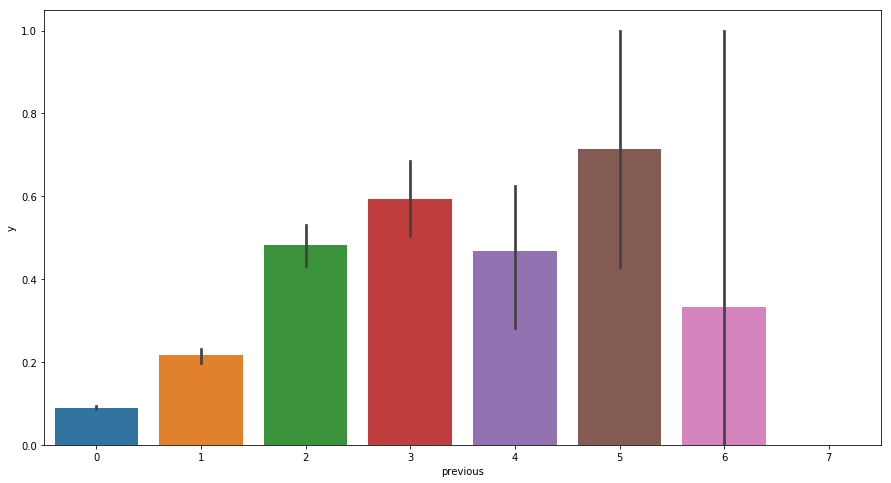

In [32]:
learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
sns.barplot(x='previous', y='y', data=learn)
plt.show()

In [34]:
### Feature - id

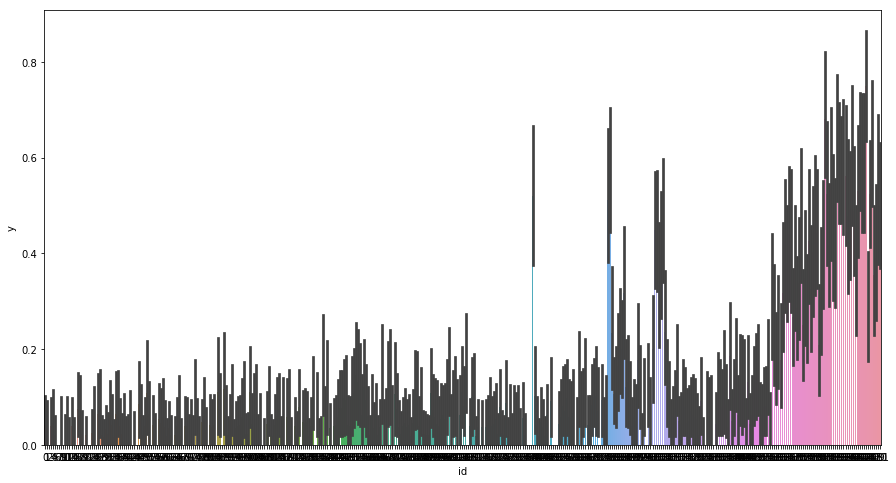

In [33]:
learn = df.loc[df['y'] != 'unknown'].copy()
learn['y'] = learn['y'].astype('int64')
learn['id'] = learn['id'].apply(lambda x: x/100)
sns.barplot(x='id', y='y', data=learn)
plt.show()

### Table types

In [22]:
for i in df.columns, df.dtypes:
    print i

Index([u'id', u'birth_date', u'job', u'marital', u'education', u'default',
       u'housing', u'loan', u'contact_date', u'contact', u'campaign', u'pdays',
       u'previous', u'poutcome', u'y', u'contact_weekday', u'contact_month',
       u'contact_day', u'birth_month'],
      dtype='object')
id                  int64
birth_date          int64
job                  int8
marital              int8
education            int8
default              int8
housing              int8
loan                 int8
contact_date        int64
contact             int64
campaign            int64
pdays               int64
previous            int64
poutcome             int8
y                  object
contact_weekday     int64
contact_month       int64
contact_day         int64
birth_month         int64
dtype: object


# 4. Learning

In [23]:
# Split data into learning and testing rows
learn = df.loc[df['y'] != 'unknown']
test = df.loc[df['y'] == 'unknown']
learn['y'] = learn['y'].astype('int64')
learn = shuffle(learn)

predictors = [x for x in learn.columns if x not in ['y']]

parameters = {
    'max_depth': 8,
    'learning_rate': 0.05,
    'min_samples_split': 200,
    'min_samples_leaf': 50,
    'max_features': 5,
    'subsample': 0.75,
    'n_estimators': 30,
}

I will tune parameters in order:
- n_estimators
- max_depth
- min_samples_split, min_samples_leaf
- max_features
- subsample

And then finally decrease learning rate and increase n_estimators to not underfit.

In [24]:
grid1 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'n_estimators':range(50, 85, 1)}, 
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=15)

grid1.fit(learn[predictors], learn['y'])
print grid1.best_params_, grid1.best_score_

parameters['n_estimators'] = grid1.best_params_['n_estimators']

{'n_estimators': 69} 0.79851634491


In [25]:
grid2 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'max_depth':range(5,11,1), 'min_samples_split':range(100, 201, 10)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=5)

grid2.fit(learn[predictors], learn['y'])
print grid2.best_params_, grid2.best_score_


parameters['max_depth'] = grid2.best_params_['max_depth']

{'min_samples_split': 170, 'max_depth': 7} 0.798184090785


In [26]:
grid3 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'min_samples_split':range(200, 250, 5), 'min_samples_leaf':range(20, 30, 1)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=5)

grid3.fit(learn[predictors], learn['y'])
print grid3.best_params_, grid3.best_score_


parameters['min_samples_split'] = grid3.best_params_['min_samples_split']
parameters['min_samples_leaf'] = grid3.best_params_['min_samples_leaf']

{'min_samples_split': 230, 'min_samples_leaf': 26} 0.798747012327


In [27]:
grid4 = GridSearchCV(estimator = GradientBoostingClassifier(**parameters),
                     param_grid = {'max_features':range(2,10,1)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=15)

grid4.fit(learn[predictors], learn['y'])
print grid4.best_params_, grid4.best_score_


parameters['max_features'] = grid4.best_params_['max_features']

{'max_features': 8} 0.79766743722


In [28]:
grid5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=27, max_depth=8, min_samples_split=240, min_samples_leaf=23, subsample=0.8, max_features=15),
                     param_grid = {'subsample': np.linspace(0.5, 0.9, 21)},
                     scoring='roc_auc',
                     n_jobs=-1,
                     cv=15)

grid5.fit(learn[predictors], learn['y'])
print grid5.best_params_, grid5.best_score_


parameters['subsample'] = grid5.best_params_['subsample']

{'subsample': 0.90000000000000002} 0.799624263342


### Generating final result - it's very slow

CV Score : Mean - 0.7990439 | Std - 0.01366999 | Min - 0.7761573 | Max - 0.8104367


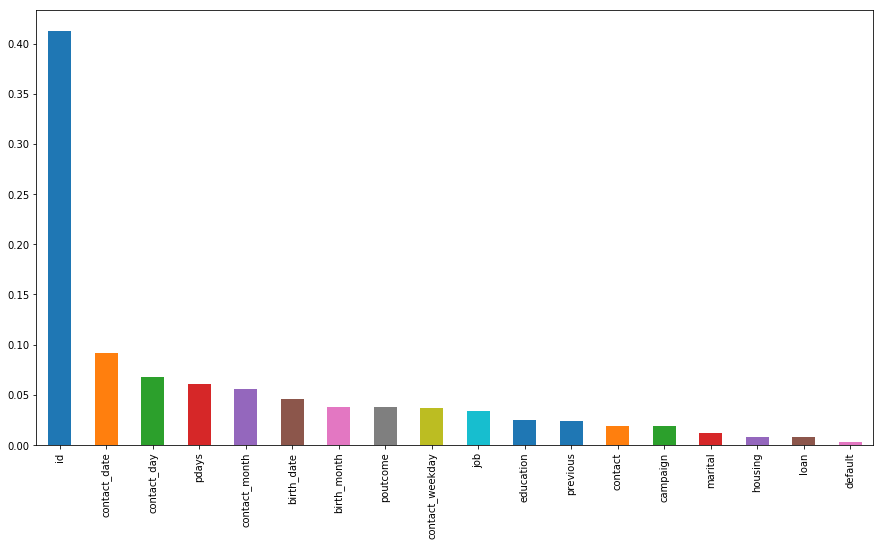

In [29]:
parameters2 = dict(parameters)
parameters2['learning_rate'] = parameters2['learning_rate'] / 50
parameters2['n_estimators'] = 75 * parameters2['n_estimators']

tune1 = GradientBoostingClassifier(**parameters2)

tune1.fit(learn[predictors], learn['y'])
cv_score = model_selection.cross_val_score(tune1, learn[predictors], learn['y'], cv=5, scoring='roc_auc')
print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

feat_imp = pd.Series(tune1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar')


# 5. Predict

In [30]:
test = df.loc[df['y'] == 'unknown']
results = tune1.predict_proba(test[predictors])
test['y'] = results
test[['id', 'y']].to_csv("results.csv", encoding='utf-8', index=False)